# SCENIC
This script runs SCENIC locally

In [1]:
import os, pandas, glob

# 0. user-defined variables

In [2]:
# input file
f_loom_path_scenic = "/home/adrian/projects/scGBM/results/pbmc10k_filtered_scenic.loom"

In [3]:
# resources
f_tfs = '/home/adrian/databases/cistarget/allTFs_hg38.txt'
database_folder = '/home/adrian/databases/cistarget/'

In [17]:
# results
results_folder = '/home/adrian/projects/scGBM/results/'
os.chdir(results_folder)
f_pyscenic_output = "pyscenic_output.loom"

In [5]:
# scenic parallelisation level. In a 20 cores machine, it failed requesting >= 12.
scenic_threads = 10

# Co-expression modules inference

This step requires to know which genes are TFs. That information was retrieved using:

`wget https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt`

This step takes around 21 CPU hours.

It is crucial to monitor for any error message in the messages file, otherwise the calculation might have failed and but still running without end.

In [6]:
cmd = 'time pyscenic grn {} {} -o adj.csv --num_workers {} > messages.from_coexpression_inference.txt 2>&1'.format(f_loom_path_scenic, f_tfs, scenic_threads)
print(cmd)

time pyscenic grn /home/adrian/projects/scGBM/results/pbmc10k_filtered_scenic.loom /home/adrian/databases/cistarget/allTFs_hg38.txt -o adj.csv --num_workers 10 > /home/adrian/projects/scGBM/results/messages.from_coexpression_inference.txt 2>&1


In [7]:
%%time
os.system(cmd)

0

In [8]:
adjacencies = pandas.read_csv("adj.csv".format(results_folder), index_col=False, sep=',')
adjacencies.head()

,TF,target,importance
0,RPS4X,RPL13,231.198714
1,RPS4X,RPS12,224.282744
2,RPS4X,RPL32,220.792059
3,RPS4X,RPS3A,214.449132
4,RPS4X,RPS23,212.291670


# Regulon inference

In [9]:
# ranking databases
f_db_glob = "{}/*feather".format(database_folder)
f_db_names = ' '.join( glob.glob(f_db_glob) )
print(f_db_names)

# motif databases
f_motif_path = "{}/motifs-v9-nr.hgnc-m0.001-o0.0.tbl".format(database_folder)
print(f_motif_path)

/home/adrian/databases/cistarget/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather /home/adrian/databases/cistarget/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather
/home/adrian/databases/cistarget//motifs-v9-nr.hgnc-m0.001-o0.0.tbl


In [13]:
cmd = 'time pyscenic ctx adj.csv {} --annotations_fname {} --expression_mtx_fname {} --output reg.csv --mask_dropouts --num_workers {} > messages.from_regulon_inference.txt 2>&1'.format(f_db_names, f_motif_path, f_loom_path_scenic, scenic_threads)

In [14]:
print(cmd)

time pyscenic ctx adj.csv /home/adrian/databases/cistarget/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather /home/adrian/databases/cistarget/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather --annotations_fname /home/adrian/databases/cistarget//motifs-v9-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname /home/adrian/projects/scGBM/results/pbmc10k_filtered_scenic.loom --output reg.csv --mask_dropouts --num_workers 10 > messages.from_regulon_inference.txt 2>&1


This step is quite memory demanding, somewhere around 4.5 GB per thread. It takes around 160 CPU minutes.

In [15]:
%%time
os.system(cmd)

CPU times: user 35.2 ms, sys: 8.7 ms, total: 43.9 ms
Wall time: 16min 11s


0

# Regulon activity

In [21]:
cmd = 'time pyscenic aucell {} reg.csv --output {} --num_workers {} > messages.from_regulon_activity.txt 2>&1'.format(f_loom_path_scenic, f_pyscenic_output, scenic_threads)

In [22]:
print(cmd)

time pyscenic aucell /home/adrian/projects/scGBM/results/pbmc10k_filtered_scenic.loom reg.csv --output pyscenic_output.loom --num_workers 10 > messages.from_regulon_activity.txt 2>&1


This process is not very memory demanding but load rises to ~18 when requesting 10 threads. Computation time is about 40 CPU minutes.

In [23]:
%%time
os.system(cmd)

CPU times: user 8.9 ms, sys: 231 µs, total: 9.13 ms
Wall time: 3min 48s


0

In [ ]:
# visualization

In [26]:
import json
import zlib
import base64
import loompy as lp
import pandas as pd

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [32]:
auc_mtx.shape

(10280, 385)

In [50]:
auc_mtx

,AHR(+),AR(+),ARID3A(+),ARNT(+),ARNTL(+),ARNTL2(+),ASCL2(+),ATF1(+),ATF2(+),ATF3(+),...,ZNF682(+),ZNF71(+),ZNF76(+),ZNF81(+),ZNF831(+),ZNF836(+),ZNF84(+),ZNF891(+),ZNF91(+),ZSCAN31(+)
AAACCCAAGCGCCCAT-1,0.000000,0.000000,0.000000,0.026675,0.043950,0.074258,0.049147,0.038690,0.033990,0.042834,...,0.000000,0.192775,0.026837,0.064039,0.117241,0.000000,0.0,0.000000,0.029525,0.000000
AAACCCACAGAGTTGG-1,0.056417,0.007548,0.000000,0.029326,0.013377,0.011400,0.034723,0.024138,0.000000,0.069177,...,0.000000,0.212479,0.021862,0.000000,0.036687,0.000000,0.0,0.000296,0.013167,0.000000
AAACCCACAGGTATGG-1,0.000000,0.012931,0.005320,0.009871,0.026084,0.000000,0.117264,0.052064,0.076108,0.035141,...,0.000000,0.012151,0.020315,0.000000,0.161939,0.000000,0.0,0.000000,0.020584,0.000000
AAACCCACATAGTCAC-1,0.055691,0.013793,0.018128,0.014309,0.039285,0.065559,0.018479,0.034619,0.000000,0.041756,...,0.000000,0.000000,0.010308,0.112419,0.083588,0.000000,0.0,0.032611,0.025080,0.000000
AAACCCACATCCAATG-1,0.000000,0.000000,0.049721,0.003407,0.042981,0.006812,0.062447,0.036108,0.000000,0.048966,...,0.100985,0.000000,0.021414,0.051180,0.122893,0.000000,0.0,0.028571,0.022801,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCTGTAAC-1,0.012497,0.002252,0.000000,0.012357,0.047471,0.023730,0.037885,0.038973,0.000000,0.046510,...,0.000000,0.000000,0.028889,0.049313,0.184496,0.008128,0.0,0.040591,0.027699,0.000000
TTTGTTGGTGCGTCGT-1,0.025564,0.043227,0.055698,0.015708,0.031683,0.039099,0.032283,0.027422,0.000000,0.043130,...,0.000000,0.000000,0.018898,0.060980,0.087581,0.014532,0.0,0.000000,0.043266,0.000000
TTTGTTGGTTTGAACC-1,0.000000,0.020179,0.037964,0.000405,0.033886,0.000000,0.052560,0.035304,0.000000,0.041757,...,0.000000,0.000000,0.025950,0.057039,0.128416,0.000000,0.0,0.000000,0.041379,0.000000
TTTGTTGTCCAAGCCG-1,0.007104,0.010925,0.017668,0.008692,0.035728,0.000000,0.031848,0.029591,0.000000,0.036192,...,0.000000,0.270936,0.014721,0.097330,0.098678,0.000000,0.0,0.000000,0.039938,0.000000


In [28]:
from MulticoreTSNE import MulticoreTSNE as TSNE


In [29]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

In [36]:
import matplotlib, matplotlib.pyplot

In [43]:
pdf = pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index)
pdf.head()


,X,Y
AAACCCAAGCGCCCAT-1,5.639293,9.727690
AAACCCACAGAGTTGG-1,12.623931,7.905836
AAACCCACAGGTATGG-1,5.661791,3.425152
AAACCCACATAGTCAC-1,6.860684,-1.972830
AAACCCACATCCAATG-1,6.209337,4.282636


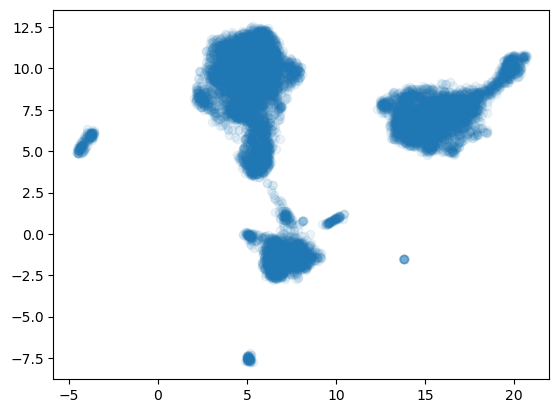

In [48]:
matplotlib.pyplot.plot(pdf['X'], pdf['Y'], 'o', alpha=1/13)
matplotlib.pyplot.show()

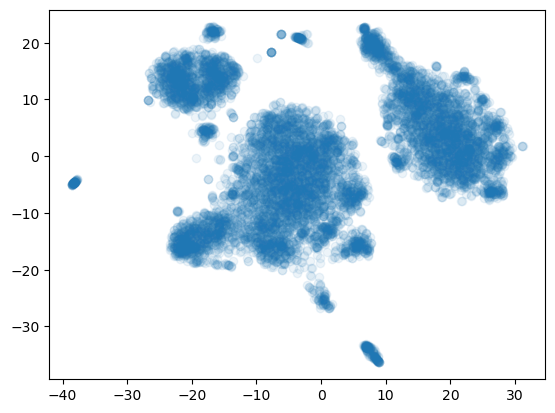

In [49]:
pdf = pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index)
matplotlib.pyplot.plot(pdf['X'], pdf['Y'], 'o', alpha=1/13)
matplotlib.pyplot.show()